In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import Point

In [2]:
def reference_point(gdf):
    """
    获得取地图数据的参照点：最北，最南，最西，最东
    """
    points = []
    for idx, row in gdf.iterrows():
        geometry = row["geometry"]
        if type(geometry) != MultiPolygon:
            polys = [geometry]
        else:
            polys = list(geometry)
        for poly in polys:
            points.extend(list(poly.exterior.coords))
    points = np.array(points)[:, :2]
    min_x_id, max_x_id, min_y_id, max_y_id = np.argmin(points[:, 0]), np.argmax(points[:, 0]), np.argmin(points[:,1]), np.argmax(points[:,1])
    return {"N": points[max_y_id], "S": points[min_y_id], "E": points[max_x_id], "W": points[min_x_id]}


def match(gdf1, gdf1_wgs84, gdf2_wgs84, rotation=0):
    """
    利用坐标系不明的地理数据gdf1的参照点和它对应的WGS84坐标系的相同参照点，计算参照点之间的XY偏差，将第2个WGS坐标系的地理数据gdf2对到gdf1的坐标系上
    以上方法只是平移，另外可通过rotation指定偏转角进行校正
    """
    raw_crs = gdf1.crs
    guide_points1 = reference_point(gdf1)
    guide_points1_refer = reference_point(gdf1_wgs84.to_crs(4547))
#     for key in ["N", "S", "E", "W"]:
#         print(f"offset for the boundary point {key}: {np.array(guide_points1[key]) - np.array(guide_points1_refer[key])}")
    offset_key = "N"
    offset = np.array(guide_points1[offset_key]) - np.array(guide_points1_refer[offset_key])
    rst = gdf2_wgs84.copy()
    rst["geometry"] = gdf2_wgs84.copy().to_crs(4547).translate(xoff=offset[0], yoff=offset[1]).rotate(angle=rotation, origin=guide_points1[offset_key])
    rst = rst.set_crs(raw_crs, allow_override=True)
    return rst


def to_float(x):
    """
    数据清洗：将x转化为float
    """
    if type(x) == float:
        return x
    elif type(x) == str:
        x = x.strip()
        try:
            return float(x)
        except:
            try:
                return float(x[:-1])
            except:
                print(f"cannot convert {x} to a float")
                return np.nan

# 读取数据

### 空间数据

In [3]:
shp_dir = r"C:\Users\wangc\iCloudDrive\shanshan_phd\00 - since_2023-1-26\new_gis\上海六普数据-DWstudio\六普gis"
gdf_raw = gpd.read_file(os.path.join(shp_dir, "六普街道.shp"), encoding="gbk")
# gdf_raw = gpd.read_file("shp/geo_info/geo_info.geojson")
geo_df = gdf_raw.copy()[["名称", "code", "SHAPE_AREA", "geometry"]]
geo_df.head()

,名称,code,SHAPE_AREA,geometry
0,半淞园,310101015,2.857751,"POLYGON Z ((2408.415 -2291.497 0.000, 2447.401..."
1,老西门,310101019,1.213371,"POLYGON Z ((2143.265 -1360.203 0.000, 2146.741..."
2,豫园,310101018,1.197668,"POLYGON Z ((1947.681 -454.298 0.000, 1969.641 ..."
3,小东门,310101017,2.627006,"POLYGON Z ((3136.980 -878.546 0.000, 3137.769 ..."
4,南京东路,310101002,2.397433,"POLYGON Z ((404.698 876.046 0.000, 411.709 875..."


### 人口属性数据

In [4]:
data = pd.read_csv("population_age_data.csv", header=[0,1])
all_cols = list(data.columns)
for idx, col in enumerate(all_cols):
    if col[0].startswith("Unnamed"):
        all_cols[idx] = (all_cols[idx-1][0], col[1])
data.columns = all_cols
data = data.loc[~data[("code", "Unnamed: 2_level_1")].isnull()]
data[("code", "Unnamed: 2_level_1")] = data[("code", "Unnamed: 2_level_1")].astype("int64")
data.head()

,"(项目, Unnamed: 0_level_1)","(代码, Unnamed: 1_level_1)","(code, Unnamed: 2_level_1)","(合计, 合计)","(合计, 男)","(合计, 女)","(0-4岁, 合计)","(0-4岁, 男)","(0-4岁, 女)","(5-9岁, 合计)",...,"(85-89岁, 女)","(90-94岁, 合计)","(90-94岁, 男)","(90-94岁, 女)","(95-99岁, 合计)","(95-99岁, 男)","(95-99岁, 女)","(100岁及以上, 合计)","(100岁及以上, 男)","(100岁及以上, 女)"
1,黄浦区,1.0,310101,429891.0,213415.0,216476.0,10680.0,5711.0,4969.0,9300.0,...,3640.0,1742.0,582.0,1160.0,302.0,110.0,192.0,24.0,9.0,15.0
2,南京东路街道,1002.0,310101002,66285.0,32694.0,33591.0,1419.0,757.0,662.0,1205.0,...,637.0,317.0,99.0,218.0,69.0,28.0,41.0,5.0,2.0,3.0
3,云南中路居委会,1002001.0,310101002001,2019.0,994.0,1025.0,39.0,17.0,22.0,30.0,...,12.0,9.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,1002001001,279.0,142.0,137.0,6.0,3.0,3.0,1.0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2,2.0,1002001002,318.0,154.0,164.0,8.0,2.0,6.0,9.0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 仅保留有意义的人口属性数据

In [5]:
age_cols = [col for col in data.columns if col[1]=="合计" and "岁" in col[0]][12:]
attr_df = data[[("项目", "Unnamed: 0_level_1"), ("code", "Unnamed: 2_level_1"), ("合计", "合计")] + age_cols].copy()
attr_df.columns = ["name", "code", "tt_pop"] + [c[0] for c in age_cols]
attr_df["keep"] = attr_df.apply(lambda row: len(str(row["code"]))==9, axis=1)
attr_df = attr_df.loc[attr_df["keep"]].drop(columns=["keep"])
attr_df.head()

,name,code,tt_pop,60-64岁,65-69岁,70-74岁,75-79岁,80-84岁,85-89岁,90-94岁,95-99岁,100岁及以上
2,南京东路街道,310101002,66285.0,4001.0,1975.0,1798.0,2566.0,1973.0,1023.0,317.0,69.0,5.0
232,外滩街道,310101013,64896.0,3352.0,1462.0,1456.0,2348.0,2046.0,1033.0,301.0,50.0,3.0
456,半淞园路街道,310101015,89776.0,5331.0,3219.0,2808.0,3203.0,1983.0,975.0,268.0,43.0,6.0
778,小东门街道,310101017,74994.0,3861.0,1853.0,1656.0,2281.0,1705.0,915.0,276.0,51.0,7.0
1032,豫园街道,310101018,61042.0,3192.0,1405.0,1238.0,1878.0,1470.0,848.0,259.0,43.0,1.0


### 全市养老院数据

In [6]:
nh_df = pd.read_csv("all_nhs.csv")
nh_df = nh_df.drop(columns=[col for col in nh_df.columns if col.startswith("Unnamed")])
nh_df["latitude"] = nh_df["latitude"].astype("float")
nh_df["longitude"] = nh_df.apply(lambda row: to_float(row["longitude"]), axis=1)
nh_df = nh_df.loc[~nh_df["latitude"].isnull()]
nh_df = gpd.GeoDataFrame(nh_df, geometry=gpd.points_from_xy(nh_df["longitude"], nh_df["latitude"]), crs=4326)
nh_df.head()

,编号,分区编号,名称,区划类型,区/街道,地址,电话,latitude,longitude,geometry
0,F-0001,PD-001,东明敬老院,街道,浦东新区东明路街道,三林永泰路1129弄96号,50652790,31.153002,121.540938,POINT (121.54094 31.15300)
1,F-0002,PD-002,春天家园老年公寓,街道,浦东新区东明路街道,上南路4276号,51380299,31.143531,121.510106,POINT (121.51011 31.14353)
2,F-0003,PD-003,世博家园颐养院,街道,浦东新区东明路街道,东泰林路158号,50658622,31.152525,121.541233,POINT (121.54123 31.15253)
3,F-0004,PD-004,沪东社区敬老院,街道,浦东新区沪东新村街道,柳埠路142弄48号,58507411,31.265009,121.582120,POINT (121.58212 31.26501)
4,F-0005,PD-005,朱家门敬老院,街道,浦东新区沪东新村街道,浦东大道2970弄31号,50351116,31.277269,121.580382,POINT (121.58038 31.27727)


### 浦东养老院数据

In [7]:
pd_nh_df = pd.read_csv("pd_nhs.csv")[["0编号", "名称",'核定床位数', '入住老人数', 'latitude', 'longitude']]
pd_nh_df["latitude"] = pd_nh_df["latitude"].astype("float")
pd_nh_df["longitude"] = pd_nh_df.apply(lambda row: to_float(row["longitude"]), axis=1)
pd_nh_df = pd_nh_df.loc[~pd_nh_df["latitude"].isnull()]
pd_nh_df = gpd.GeoDataFrame(pd_nh_df, geometry=gpd.points_from_xy(pd_nh_df["longitude"], pd_nh_df["latitude"]), crs=4326)
pd_nh_df.head()

,0编号,名称,核定床位数,入住老人数,latitude,longitude,geometry
0,PD-001,东明敬老院,93.0,93.0,31.153002,121.540938,POINT (121.54094 31.15300)
1,PD-002,春天家园老年公寓,175.0,175.0,31.143531,121.510106,POINT (121.51011 31.14353)
2,PD-003,世博家园颐养院,200.0,194.0,31.152525,121.541233,POINT (121.54123 31.15253)
3,PD-004,沪东社区敬老院,68.0,55.0,31.265009,121.582120,POINT (121.58212 31.26501)
4,PD-005,朱家门敬老院,115.0,106.0,31.277269,121.580382,POINT (121.58038 31.27727)


# 不匹配问题

### 空间数据与人口属性数据的街道单元不能完全匹配

In [8]:
tmp = attr_df.merge(geo_df, how="outer", left_on="code", right_on="code")
print(f"合并前：空间数据有{len(geo_df)}个街道，属性数据有{len(attr_df)}个街道，基于code合并后，共有{len(tmp)}条街道的记录")
print("以下记录未能正确匹配：")
tmp.loc[tmp["名称"].isnull() | tmp["name"].isnull(), ["code", "name", "名称"]].rename(columns={"name": "name in 属性数据", "名称": "name in 空间数据"})

合并前：空间数据有230个街道，属性数据有230个街道，基于code合并后，共有251条街道的记录
以下记录未能正确匹配：


,code,name in 属性数据,name in 空间数据
209,310130101,城桥镇,NaN
210,310130102,堡镇,NaN
211,310130103,新河镇,NaN
212,310130104,庙镇,NaN
213,310130106,竖新镇,NaN
214,310130107,向化镇,NaN
215,310130109,三星镇,NaN
216,310130113,港沿镇,NaN
217,310130114,中兴镇,NaN
218,310130115,陈家镇,NaN


于是我们发现没匹配到的街道名称是一样的，只是code发生了变化，然而，我们也不能基于名称匹配，因为用code匹配上的街道，命名方式又不完全一样，例如下面的：

In [9]:
tmp.loc[~tmp["名称"].isnull() & ~tmp["name"].isnull(), ["code", "name", "名称"]].rename(columns={"name": "name in 属性数据", "名称": "name in 空间数据"}).head()

,code,name in 属性数据,name in 空间数据
0,310101002,南京东路街道,南京东路
1,310101013,外滩街道,外滩
2,310101015,半淞园路街道,半淞园
3,310101017,小东门街道,小东门
4,310101018,豫园街道,豫园


所以我们还是以code进行合并，只是预先把不一致的code以名称为索引改成一致，作为新的一列，code_new

In [10]:
attr_name_to_code = {record["name"].strip(): record["code"] for record in  attr_df[["code", "name"]].to_dict("records")}
geo_name_to_code = {record["名称"].strip(): record["code"] for record in geo_df[["code", "名称"]].to_dict("records")}
num = 0
for name, geo_code in geo_name_to_code.items():
    if name in attr_name_to_code and attr_name_to_code[name] != geo_code:
        attr_name_to_code[name] = geo_code
        num += 1
print(f"共记{num}个code被修改（基于相同的街道名称），前后对比如下：")
attr_df["code_new"] = list(attr_name_to_code.values())
attr_df.loc[attr_df["code"] != attr_df["code_new"], ["name", "code", "code_new"]]

共记21个code被修改（基于相同的街道名称），前后对比如下：


,name,code,code_new
87965,城桥镇,310130101,310230101
88527,堡镇,310130102,310230102
89043,新河镇,310130103,310230103
89271,庙镇,310130104,310230104
89562,竖新镇,310130106,310230106
89773,向化镇,310130107,310230107
89922,三星镇,310130109,310230109
90104,港沿镇,310130113,310230113
90364,中兴镇,310130114,310230114
90494,陈家镇,310130115,310230115


## 重新匹配，可完全匹配

In [11]:
merge_df = attr_df.merge(geo_df, how="inner", left_on="code_new", right_on="code", suffixes= ("", "_geo"))
print(f"合并前：空间数据有{len(geo_df)}个街道，属性数据有{len(attr_df)}个街道，基于code_new合并后，共有{len(merge_df)}条街道的记录")
merge_df = gpd.GeoDataFrame(merge_df, geometry="geometry").set_index("name")
merge_df.head()

合并前：空间数据有230个街道，属性数据有230个街道，基于code_new合并后，共有230条街道的记录


,code,tt_pop,60-64岁,65-69岁,70-74岁,75-79岁,80-84岁,85-89岁,90-94岁,95-99岁,100岁及以上,code_new,名称,code_geo,SHAPE_AREA,geometry
name,,,,,,,,,,,,,,,,
南京东路街道,310101002,66285.0,4001.0,1975.0,1798.0,2566.0,1973.0,1023.0,317.0,69.0,5.0,310101002,南京东路,310101002,2.397433,"POLYGON Z ((404.698 876.046 0.000, 411.709 875..."
外滩街道,310101013,64896.0,3352.0,1462.0,1456.0,2348.0,2046.0,1033.0,301.0,50.0,3.0,310101013,外滩,310101013,2.189376,"POLYGON Z ((1540.875 1174.904 0.000, 1647.257 ..."
半淞园路街道,310101015,89776.0,5331.0,3219.0,2808.0,3203.0,1983.0,975.0,268.0,43.0,6.0,310101015,半淞园,310101015,2.857751,"POLYGON Z ((2408.415 -2291.497 0.000, 2447.401..."
小东门街道,310101017,74994.0,3861.0,1853.0,1656.0,2281.0,1705.0,915.0,276.0,51.0,7.0,310101017,小东门,310101017,2.627006,"POLYGON Z ((3136.980 -878.546 0.000, 3137.769 ..."
豫园街道,310101018,61042.0,3192.0,1405.0,1238.0,1878.0,1470.0,848.0,259.0,43.0,1.0,310101018,豫园,310101018,1.197668,"POLYGON Z ((1947.681 -454.298 0.000, 1969.641 ..."


### 不同坐标系之间无法对齐

下面4张图：
- 第一行是六普街道GIS数据，第二行是在网上找的WGS84坐标的上海街道数据
- 第一列是把它们都转成六普街道GIS的坐标系（CRS未知的XY投影坐标），第二列是都用WGS84坐标（经纬度）

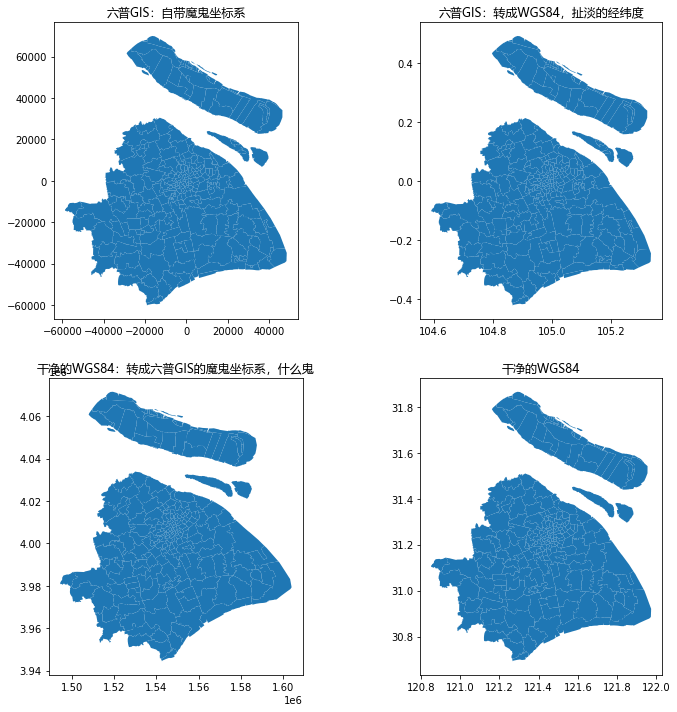

In [12]:
%matplotlib inline
sh_wgs84 = gpd.read_file("shp/shanghai_wgs84/shanghai1.shp", encoding="utf8")

fig, axes = plt.subplots(2,2, figsize=(12,12))
geo_df.plot(ax=axes[0,0])
geo_df.to_crs(4326).plot(ax=axes[0,1])
sh_wgs84.to_crs(geo_df.crs).plot(ax=axes[1,0])
sh_wgs84.plot(ax=axes[1,1])

_ = axes[0,0].set_title("六普GIS：自带魔鬼坐标系", font="Microsoft Yahei", fontsize=12)
_ = axes[0,1].set_title("六普GIS：转成WGS84，扯淡的经纬度", font="Microsoft Yahei", fontsize=12)
_ = axes[1,0].set_title("干净的WGS84：转成六普GIS的魔鬼坐标系，什么鬼", font="Microsoft Yahei", fontsize=12)
_ = axes[1,1].set_title("干净的WGS84", font="Microsoft Yahei", fontsize=12)

### 对齐坐标系

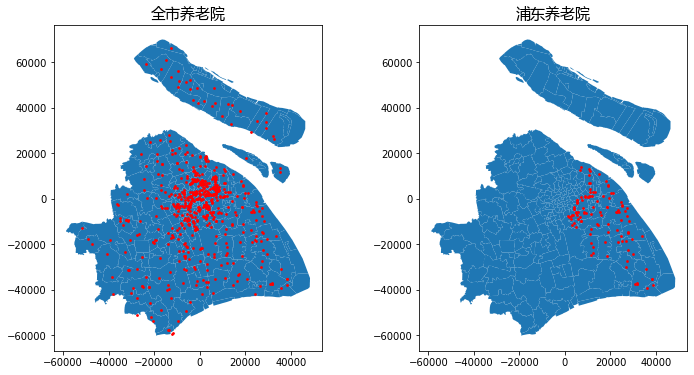

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
nh_df2 = match(geo_df, sh_wgs84, nh_df, rotation=-4)
pd_nh_df2 = match(geo_df, sh_wgs84, pd_nh_df, rotation=-4)
_ = geo_df.plot(ax=ax1)
_ = nh_df2.plot(ax=ax1, color="red", markersize=3)
_ = geo_df.plot(ax=ax2)
_ = pd_nh_df2.plot(ax=ax2, color="red", markersize=3)

_ = ax1.set_title("全市养老院", font="Microsoft Yahei", fontsize=15)
_ = ax2.set_title("浦东养老院", font="Microsoft Yahei", fontsize=15)

### 其实还是没对齐，有养老院落在外面，或者，全部使用WGS84坐标系?

依然不行，即使拿WGS84的上海，也有养老院落在外面，那应该是火星坐标系之类的原因了

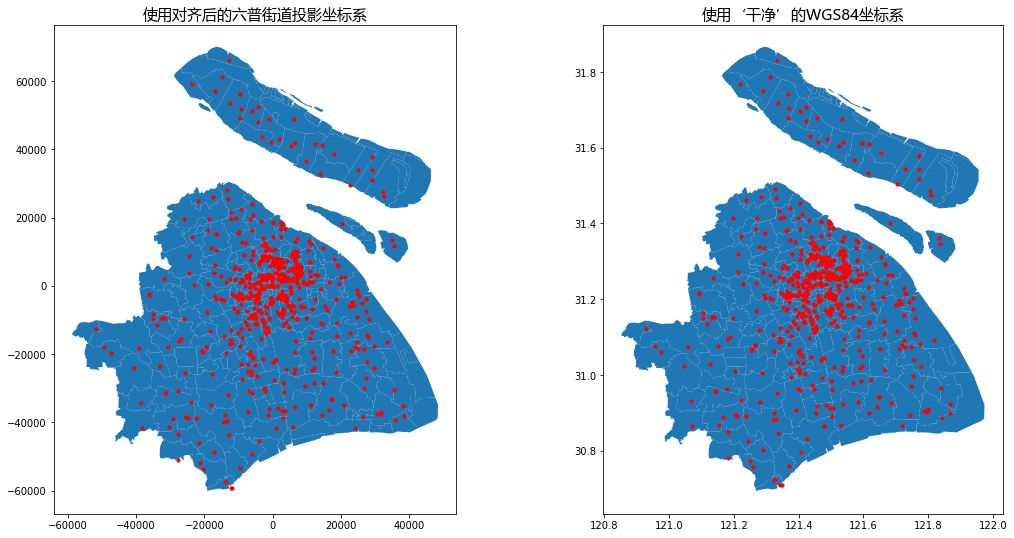

In [14]:
fig, (axx, axx2) = plt.subplots(1,2, figsize=(18,9))
nh_df3 = match(geo_df, sh_wgs84, nh_df, rotation=-4)
_ = geo_df.plot(ax=axx)
_ = nh_df3.plot(ax=axx, color="red", markersize=10)
_ = axx.set_title("使用对齐后的六普街道投影坐标系", font="Microsoft Yahei", fontsize=15)

_ = sh_wgs84.plot(ax=axx2)
_ = nh_df.plot(ax=axx2, color="red", markersize=10)
_ = axx2.set_title("使用‘干净’的WGS84坐标系", font="Microsoft Yahei", fontsize=15)

然而转成火星坐标系或百度坐标系还是不行啊，放弃，就这样吧

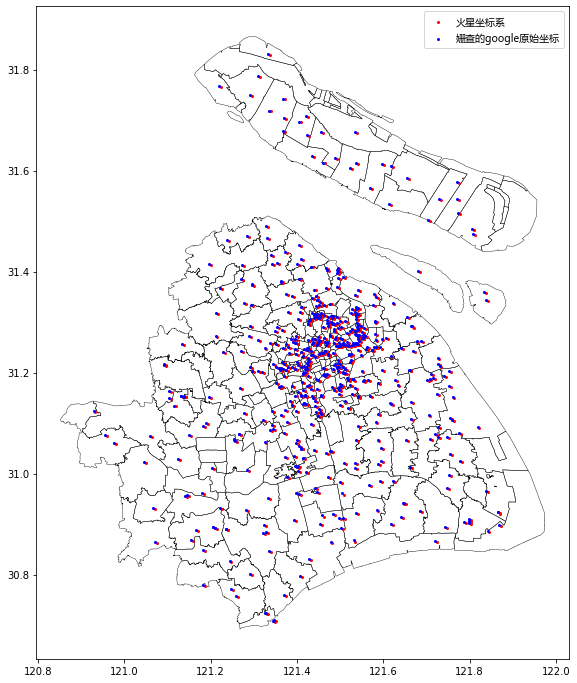

In [15]:
from coordTransform_utils import wgs84_to_gcj02, wgs84_to_bd09
def point_wgs84_to_gcj02(point):
    lng, lat = point.x, point.y
    return Point(wgs84_to_gcj02(lng, lat))

nh_df_gcj02 = nh_df.copy()
nh_df_gcj02["geometry"] = nh_df_gcj02.apply(lambda row: point_wgs84_to_gcj02(row["geometry"]), axis=1)

fig, ax3 = plt.subplots(1,1, figsize=(12, 12))

_ = sh_wgs84.plot(ax=ax3, facecolor="none", lw=0.4)
_ = nh_df_gcj02.plot(ax=ax3, color="red", markersize=4, label="火星坐标系")
_ = nh_df.plot(ax=ax3, color="blue", markersize=4, label="姗查的google原始坐标")
plt.legend(prop={"family":"Microsoft Yahei"})

# 数据分析

### 人口属性数据

In [16]:
# 老年人口总量
merge_df["elder_pop"] = merge_df[[c[0] for c in age_cols]].sum(axis=1).astype(int)

# 老年人口比例(%)
merge_df["elder_share"] = 100 * merge_df["elder_pop"]  / merge_df["tt_pop"] 

# 老年人口密度(人/km2)
merge_df["elder_density"] = merge_df["elder_pop"]  / merge_df["SHAPE_AREA"] 

# 95岁以上老年人数量
merge_df["95岁及以上"] = merge_df["95-99岁"]  + merge_df["100岁及以上"] 

# 低龄老人
merge_df["低龄老人"] = merge_df["60-64岁"]  + merge_df["65-69岁"] 

# 中龄老人
merge_df["中龄老人"] = merge_df["70-74岁"]  + merge_df["75-79岁"] 

# 高龄老人
merge_df["高龄老人"] = merge_df["80-84岁"]  + merge_df["85-89岁"] + merge_df["90-94岁"] + merge_df["95岁及以上"]
 

merge_df.head()

,code,tt_pop,60-64岁,65-69岁,70-74岁,75-79岁,80-84岁,85-89岁,90-94岁,95-99岁,...,code_geo,SHAPE_AREA,geometry,elder_pop,elder_share,elder_density,95岁及以上,低龄老人,中龄老人,高龄老人
name,,,,,,,,,,,,,,,,,,,,,
南京东路街道,310101002,66285.0,4001.0,1975.0,1798.0,2566.0,1973.0,1023.0,317.0,69.0,...,310101002,2.397433,"POLYGON Z ((404.698 876.046 0.000, 411.709 875...",13727,20.709059,5725.708302,74.0,5976.0,4364.0,3387.0
外滩街道,310101013,64896.0,3352.0,1462.0,1456.0,2348.0,2046.0,1033.0,301.0,50.0,...,310101013,2.189376,"POLYGON Z ((1540.875 1174.904 0.000, 1647.257 ...",12051,18.569712,5504.307204,53.0,4814.0,3804.0,3433.0
半淞园路街道,310101015,89776.0,5331.0,3219.0,2808.0,3203.0,1983.0,975.0,268.0,43.0,...,310101015,2.857751,"POLYGON Z ((2408.415 -2291.497 0.000, 2447.401...",17836,19.867225,6241.271229,49.0,8550.0,6011.0,3275.0
小东门街道,310101017,74994.0,3861.0,1853.0,1656.0,2281.0,1705.0,915.0,276.0,51.0,...,310101017,2.627006,"POLYGON Z ((3136.980 -878.546 0.000, 3137.769 ...",12605,16.808011,4798.237165,58.0,5714.0,3937.0,2954.0
豫园街道,310101018,61042.0,3192.0,1405.0,1238.0,1878.0,1470.0,848.0,259.0,43.0,...,310101018,1.197668,"POLYGON Z ((1947.681 -454.298 0.000, 1969.641 ...",10334,16.929327,8628.434607,44.0,4597.0,3116.0,2621.0


### 全市养老院数据 

In [17]:
# 与养老院空间链接，每街道养老院数量
merge_df["num_nhs"] = gpd.sjoin(nh_df2, merge_df.reset_index()).groupby("name").count()["编号"]
merge_df["num_nhs"] = merge_df["num_nhs"].fillna(0).astype(int)
merge_df.head()

# 养老院服务人口数
merge_df["elder_per_nh"] =  merge_df["elder_pop"] / merge_df["num_nhs"]
merge_df.loc[merge_df["elder_per_nh"]==np.inf, "elder_per_nh"] = 0
merge_df.head()

,code,tt_pop,60-64岁,65-69岁,70-74岁,75-79岁,80-84岁,85-89岁,90-94岁,95-99岁,...,geometry,elder_pop,elder_share,elder_density,95岁及以上,低龄老人,中龄老人,高龄老人,num_nhs,elder_per_nh
name,,,,,,,,,,,,,,,,,,,,,
南京东路街道,310101002,66285.0,4001.0,1975.0,1798.0,2566.0,1973.0,1023.0,317.0,69.0,...,"POLYGON Z ((404.698 876.046 0.000, 411.709 875...",13727,20.709059,5725.708302,74.0,5976.0,4364.0,3387.0,5,2745.400000
外滩街道,310101013,64896.0,3352.0,1462.0,1456.0,2348.0,2046.0,1033.0,301.0,50.0,...,"POLYGON Z ((1540.875 1174.904 0.000, 1647.257 ...",12051,18.569712,5504.307204,53.0,4814.0,3804.0,3433.0,1,12051.000000
半淞园路街道,310101015,89776.0,5331.0,3219.0,2808.0,3203.0,1983.0,975.0,268.0,43.0,...,"POLYGON Z ((2408.415 -2291.497 0.000, 2447.401...",17836,19.867225,6241.271229,49.0,8550.0,6011.0,3275.0,9,1981.777778
小东门街道,310101017,74994.0,3861.0,1853.0,1656.0,2281.0,1705.0,915.0,276.0,51.0,...,"POLYGON Z ((3136.980 -878.546 0.000, 3137.769 ...",12605,16.808011,4798.237165,58.0,5714.0,3937.0,2954.0,3,4201.666667
豫园街道,310101018,61042.0,3192.0,1405.0,1238.0,1878.0,1470.0,848.0,259.0,43.0,...,"POLYGON Z ((1947.681 -454.298 0.000, 1969.641 ...",10334,16.929327,8628.434607,44.0,4597.0,3116.0,2621.0,0,0.000000


### 浦东养老院数据

In [18]:
pd_nh_df2["入住老人数"] = pd_nh_df2.apply(lambda row: to_float(row["入住老人数"]), axis=1)
pd_nh_df2["核定床位数"] = pd_nh_df2.apply(lambda row: to_float(row["核定床位数"]), axis=1)
pd_nh_df2 = pd_nh_df2.loc[~pd_nh_df2["入住老人数"].isnull() & ~pd_nh_df2["核定床位数"].isnull()]
pd_nh_df2["occupancy_rate"] = pd_nh_df2["入住老人数"] / pd_nh_df2["核定床位数"]
pd_nh_df2["vacant_beds"] = pd_nh_df2["核定床位数"] - pd_nh_df2["入住老人数"]
pd_nh_df2.head()

C:\Users\wangc\Anaconda3\envs\neom\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,0编号,名称,核定床位数,入住老人数,latitude,longitude,geometry,occupancy_rate,vacant_beds
0,PD-001,东明敬老院,93.0,93.0,31.153002,121.540938,POINT (7011.030 -9636.695),1.000000,0.0
1,PD-002,春天家园老年公寓,175.0,175.0,31.143531,121.510106,POINT (4050.603 -10688.772),1.000000,0.0
2,PD-003,世博家园颐养院,200.0,194.0,31.152525,121.541233,POINT (7039.262 -9689.960),0.970000,6.0
3,PD-004,沪东社区敬老院,68.0,55.0,31.265009,121.582120,POINT (10974.863 2857.178),0.808824,13.0
4,PD-005,朱家门敬老院,115.0,106.0,31.277269,121.580382,POINT (10809.416 4225.401),0.921739,9.0


# 绘图

In [19]:
merge_centroid_df = merge_df.copy()
merge_centroid_df["geometry"] = merge_centroid_df.apply(lambda row: row["geometry"].centroid, axis=1)
merge_centroid_df["低龄老人_norm"] = 70 * (merge_centroid_df["低龄老人"]-merge_centroid_df["低龄老人"].min()) / (merge_centroid_df["低龄老人"].max() - merge_centroid_df["低龄老人"].min())
merge_centroid_df["中龄老人_norm"] = 70 * (merge_centroid_df["中龄老人"]-merge_centroid_df["中龄老人"].min()) / (merge_centroid_df["中龄老人"].max() - merge_centroid_df["中龄老人"].min())
merge_centroid_df["高龄老人_norm"] = 70 * (merge_centroid_df["高龄老人"]-merge_centroid_df["高龄老人"].min()) / (merge_centroid_df["高龄老人"].max() - merge_centroid_df["高龄老人"].min())

In [20]:
merge_df.columns

Index(['code', 'tt_pop', '60-64岁', '65-69岁', '70-74岁', '75-79岁', '80-84岁',
       '85-89岁', '90-94岁', '95-99岁', '100岁及以上', 'code_new', '名称', 'code_geo',
       'SHAPE_AREA', 'geometry', 'elder_pop', 'elder_share', 'elder_density',
       '95岁及以上', '低龄老人', '中龄老人', '高龄老人', 'num_nhs', 'elder_per_nh'],
      dtype='object')

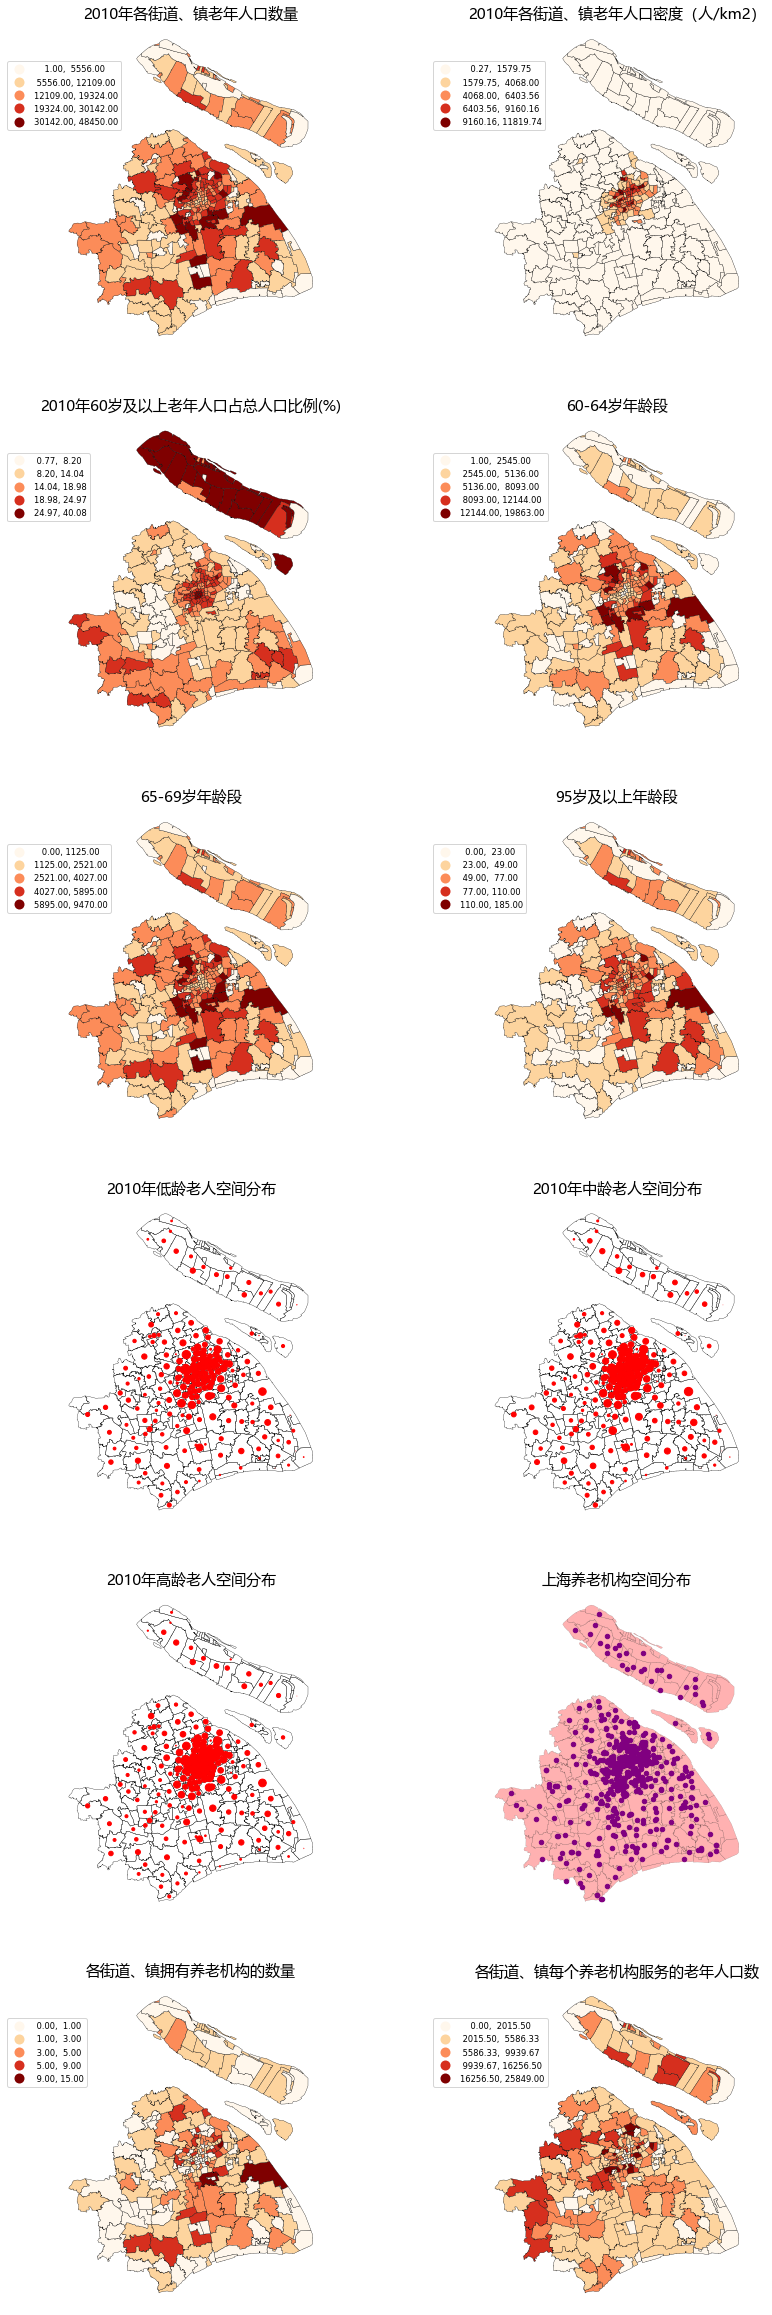

In [21]:
fig, axes = plt.subplots(6,2, figsize=(14, 42))


merge_df.plot(ax=axes[0,0], column='elder_pop', cmap='OrRd', scheme='natural_breaks', edgecolor="k", linewidth=0.3, 
              legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 'small', 'bbox_to_anchor': (-0.2, 0.9)})
axes[0,0].set_title("2010年各街道、镇老年人口数量", font="Microsoft Yahei", fontsize=15)



merge_df.plot(ax=axes[0,1], column='elder_density', cmap='OrRd', scheme='natural_breaks', edgecolor="k", linewidth=0.3, 
              legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 'small', 'bbox_to_anchor': (-0.2, 0.9)})
axes[0,1].set_title("2010年各街道、镇老年人口密度（人/km2）", font="Microsoft Yahei", fontsize=15)



merge_df.plot(ax=axes[1,0], column='elder_share', cmap='OrRd', scheme='natural_breaks', edgecolor="k", linewidth=0.3, 
              legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 'small', 'bbox_to_anchor': (-0.2, 0.9)})
axes[1,0].set_title("2010年60岁及以上老年人口占总人口比例(%)", font="Microsoft Yahei", fontsize=15)



merge_df.plot(ax=axes[1,1], column='60-64岁', cmap='OrRd', scheme='natural_breaks', edgecolor="k", linewidth=0.3, 
              legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 'small', 'bbox_to_anchor': (-0.2, 0.9)})
axes[1,1].set_title("60-64岁年龄段", font="Microsoft Yahei", fontsize=15)



merge_df.plot(ax=axes[2,0], column='65-69岁', cmap='OrRd', scheme='natural_breaks', edgecolor="k", linewidth=0.3, 
              legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 'small', 'bbox_to_anchor': (-0.2, 0.9)})
axes[2,0].set_title("65-69岁年龄段", font="Microsoft Yahei", fontsize=15)



merge_df.plot(ax=axes[2,1], column='95岁及以上', cmap='OrRd', scheme='natural_breaks', edgecolor="k", linewidth=0.3, 
              legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 'small', 'bbox_to_anchor': (-0.2, 0.9)})
axes[2,1].set_title("95岁及以上年龄段", font="Microsoft Yahei", fontsize=15)



merge_df.plot(ax=axes[3,0], edgecolor="k", linewidth=0.3, facecolor="none")
merge_centroid_df.plot(ax=axes[3,0], color="red", markersize="低龄老人_norm")
axes[3,0].set_title("2010年低龄老人空间分布", font="Microsoft Yahei", fontsize=15)



merge_df.plot(ax=axes[3,1], edgecolor="k", linewidth=0.3, facecolor="none")
merge_centroid_df.plot(ax=axes[3,1], color="red", markersize="中龄老人_norm")
axes[3,1].set_title("2010年中龄老人空间分布", font="Microsoft Yahei", fontsize=15)



merge_df.plot(ax=axes[4,0], edgecolor="k", linewidth=0.3, facecolor="none")
merge_centroid_df.plot(ax=axes[4,0], color="red", markersize="高龄老人_norm")
axes[4,0].set_title("2010年高龄老人空间分布", font="Microsoft Yahei", fontsize=15)



merge_df.plot(ax=axes[4,1], edgecolor="k", linewidth=0.3, facecolor="red", alpha=0.3)
nh_df2.plot(ax=axes[4,1], color="purple", markersize=20)
axes[4,1].set_title("上海养老机构空间分布", font="Microsoft Yahei", fontsize=15)



merge_df.plot(ax=axes[5,0], column='num_nhs', cmap='OrRd', scheme='natural_breaks', edgecolor="k", linewidth=0.3, 
              legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 'small', 'bbox_to_anchor': (-0.2, 0.9)})
axes[5,0].set_title("各街道、镇拥有养老机构的数量", font="Microsoft Yahei", fontsize=15)



merge_df.plot(ax=axes[5,1], column='elder_per_nh', cmap='OrRd', scheme='natural_breaks', edgecolor="k", linewidth=0.3, 
              legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 'small', 'bbox_to_anchor': (-0.2, 0.9)})
axes[5,1].set_title("各街道、镇每个养老机构服务的老年人口数", font="Microsoft Yahei", fontsize=15)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i, j].axis("off")

# 保存

因为未知的编码原因，无法直接保存为shp文件，先转为geojson，然后加上如下CRS信息后（来自原六普街道.shp导出geojson中包含的CRS），在QGIS中转存为shp文件：  
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:ESRI::102012" } },

In [22]:
merge_df.to_file("output/zones_and_population.geojson", encoding="utf-8", driver='GeoJSON')
nh_df2.to_file("output/all_nursing_homes.geojson", encoding="utf-8", driver='GeoJSON')
pd_nh_df2.to_file("output/pudong_nursing_homes.geojson", encoding="utf-8", driver='GeoJSON')